# Задание
  1. Использовать DecisionTreeClassifier и DecisionTreeRegressor для наборов данных своего варианта.
  2. Использовать [ансамбли](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) для наборов данных своего варианта:
    - BaggingClassifier
    - BaggingRegressor
    - GradientBoostingClassifier
    - GradientBoostingRegressor
    - StackingClassifier
    - StackingRegressor
  3. Попробовать для решения задачи регрессии и классификации одну из библиотек (на выбор): 
    - [Catboost](https://catboost.ai/en/docs/concepts/python-usages-examples), 
    - [XGBoost](https://xgboost.readthedocs.io/en/stable/get_started.html), 
    - [LightGBM](https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/simple_example.py)
  4. Реализовать обучения и вычисления дерева с использованием алгоритма CART для задачи регрессии и классификации.
  5. Доп. задание: реализовать(на выбор) бустинг или бэггинг.

In [27]:
from pathlib import Path
import os
import sys

sys.path.append(str(Path(os.getcwd()).parent))

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from sklearn.tree import plot_tree

## 1. Предобработка для классификации

In [29]:
table_classification = pd.read_csv("../data/neo_task_compleated.csv")
table_classification

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,0.016016,0.035813,56014.078517,1.024333e+06,26.10,False
1,0.030518,0.068240,7864.348060,3.268186e+07,24.70,False
2,0.055533,0.124177,55257.544508,6.538636e+07,23.40,False
3,0.019256,0.043057,41531.404722,1.260796e+07,25.70,False
4,0.139494,0.311918,67639.394481,7.130590e+07,21.40,False
...,...,...,...,...,...,...
90831,0.017561,0.039268,23264.740825,1.635007e+06,25.90,False
90832,0.110804,0.247765,24802.519406,3.351901e+07,21.90,False
90833,0.035039,0.078350,116288.999548,5.471396e+07,24.40,False
90834,0.044112,0.098637,45763.317060,2.694877e+07,23.90,False


In [30]:
X_classification = np.array(table_classification.drop(columns=['hazardous'], axis=1))
y_classification = np.array(table_classification['hazardous'])
columns = table_classification.drop(columns=['hazardous'], axis=1).columns

In [31]:
# Дисбаланс классов

smt = SMOTE()
X, y = smt.fit_resample(X_classification, y_classification)
print(X.shape, y.shape)

# X, y = X_classification, y_classification

(163992, 5) (163992,)


Без SMOTE очень плохие результаты у 2 класса!

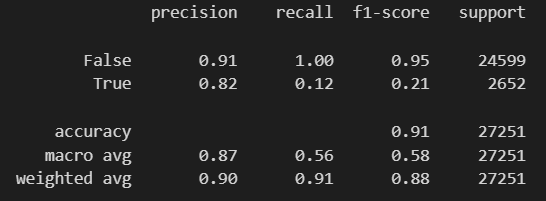

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True)

In [33]:
# Масштабирование

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train

array([[-6.12961355e-01, -6.12682868e-01,  3.24308951e-01,
        -6.29643439e-01,  1.16528098e+00],
       [ 5.28945420e-01,  5.31168334e-01,  1.02398673e+00,
        -5.53404000e-01, -9.78819127e-01],
       [-6.15464067e-01, -6.15189842e-01, -2.06281521e-01,
         6.90171655e-01,  1.19059371e+00],
       ...,
       [ 2.26578824e-01,  2.28286871e-01, -1.73207483e+00,
         1.28050328e+00, -7.62102743e-01],
       [ 3.62648293e-01,  3.64588038e-01, -7.92583079e-01,
         1.60040594e+00, -8.70585879e-01],
       [-2.47717190e-03, -1.15915875e-03,  7.76641149e-01,
        -5.02956594e-01, -4.14692077e-01]])

## 2. Обучение моделей решающих деревьев для классификации

In [34]:
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, StackingClassifier

In [35]:
# DecisionTreeClassifier

grid = {
    'max_depth': np.arange(3, 5, 1),
    'criterion': ["gini", "entropy", "log_loss"]
}

dt = GridSearchCV(DecisionTreeClassifier(), grid).fit(X_train, y_train)
y_pred = dt.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.78      0.87     24599
        True       0.82      0.99      0.90     24599

    accuracy                           0.88     49198
   macro avg       0.90      0.88      0.88     49198
weighted avg       0.90      0.88      0.88     49198



In [36]:
dt.best_params_

{'criterion': 'gini', 'max_depth': 4}

In [37]:
# fig = plt.figure(figsize=(20, 20))
# _ = plot_tree(dt.best_estimator_, filled=True)

In [38]:
print(dt.estimator)

DecisionTreeClassifier()


In [42]:
# BaggingClassifier with Naive Bayes

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

grid_knn = {
    'n_neighbors': np.arange(5, 11, 2),
    'p': np.array([1, 2])
}

log_reg_grid = {
    'C': np.array([0.01, 0.05, 0.1, 0.5, 1, 5, 10])
}

grid_bagging = {
    'estimator': [GridSearchCV(KNeighborsClassifier(), grid_knn).fit(X_train, y_train).best_estimator_, 
                  GridSearchCV(LogisticRegression(), log_reg_grid).fit(X_train, y_train).best_estimator_],
    'n_estimators': np.arange(9, 15, 2),
}

dt = GridSearchCV(BaggingClassifier(), grid_bagging).fit(X_train, y_train)
y_pred = dt.predict(X_test[:100])
print(classification_report(y_test[:100], y_pred[:100]))


              precision    recall  f1-score   support

       False       1.00      0.62      0.77        53
        True       0.70      1.00      0.82        47

    accuracy                           0.80       100
   macro avg       0.85      0.81      0.80       100
weighted avg       0.86      0.80      0.79       100



In [43]:
dt.best_params_

{'estimator': KNeighborsClassifier(n_neighbors=9, p=1), 'n_estimators': 11}